In [116]:
# Import PyTorch and matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn  # nn contains all of PyTorch's building blocks for neural networks
from torch.backends import mps

# Check PyTorch version
torch.__version__

'2.0.1+cpu'

In [117]:
# Setup device agnostic code
device = "mps" if mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [118]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.01

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(
    dim=1
)  # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X, y = X.to(device), y.to(device)

In [119]:
X.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [120]:
# split data into train and test sets using pytorch
a = torch.randperm(len(X))
print(a)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
print(train_size, test_size)

tensor([76, 59, 48, 42, 32, 49, 70,  3, 98, 63, 90, 25, 91, 92, 51, 11, 67, 60,
        73, 72, 53, 44, 75, 56, 20, 94, 27, 64, 40, 14, 65, 24, 45, 71,  9, 81,
        84, 15, 58,  6, 77,  0,  5,  2, 29, 54, 18, 19, 78, 52, 39,  8, 74, 21,
        95, 69, 82, 66, 36, 55, 80, 28, 26, 31, 79,  4, 99, 17, 85, 10,  7, 93,
        47, 22, 68, 23,  1, 96, 37, 16, 61, 13, 86, 30, 97, 88, 38, 87, 83, 46,
        50, 89, 12, 43, 41, 57, 35, 33, 34, 62])
80 20


In [121]:
train_idx = a[:train_size]
test_idx = a[-test_size:]
print(train_idx, test_idx)

tensor([76, 59, 48, 42, 32, 49, 70,  3, 98, 63, 90, 25, 91, 92, 51, 11, 67, 60,
        73, 72, 53, 44, 75, 56, 20, 94, 27, 64, 40, 14, 65, 24, 45, 71,  9, 81,
        84, 15, 58,  6, 77,  0,  5,  2, 29, 54, 18, 19, 78, 52, 39,  8, 74, 21,
        95, 69, 82, 66, 36, 55, 80, 28, 26, 31, 79,  4, 99, 17, 85, 10,  7, 93,
        47, 22, 68, 23,  1, 96, 37, 16]) tensor([61, 13, 86, 30, 97, 88, 38, 87, 83, 46, 50, 89, 12, 43, 41, 57, 35, 33,
        34, 62])


In [122]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [123]:
def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

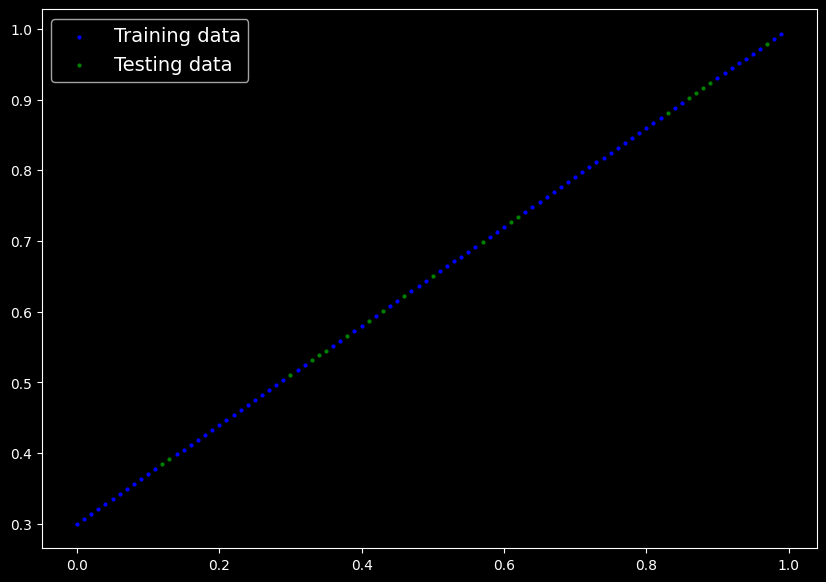

In [124]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [125]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [126]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [127]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(
    device
)  # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

In [128]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(), lr=0.01  # optimize newly created model's parameters
)

In [129]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 200

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()  # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval()  # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5611881017684937 | Test loss: 0.5523990392684937
Epoch: 10 | Train loss: 0.43784719705581665 | Test loss: 0.426189661026001
Epoch: 20 | Train loss: 0.31450626254081726 | Test loss: 0.2999802231788635
Epoch: 30 | Train loss: 0.19116537272930145 | Test loss: 0.1737707257270813
Epoch: 40 | Train loss: 0.06782446801662445 | Test loss: 0.04851411283016205
Epoch: 50 | Train loss: 0.03626358509063721 | Test loss: 0.0305227842181921
Epoch: 60 | Train loss: 0.03067798539996147 | Test loss: 0.02573920413851738
Epoch: 70 | Train loss: 0.025453388690948486 | Test loss: 0.021283211186528206
Epoch: 80 | Train loss: 0.020238522440195084 | Test loss: 0.016831140965223312
Epoch: 90 | Train loss: 0.015023658983409405 | Test loss: 0.012379081919789314
Epoch: 100 | Train loss: 0.009808793663978577 | Test loss: 0.007927009835839272
Epoch: 110 | Train loss: 0.004593930207192898 | Test loss: 0.0034749433398246765
Epoch: 120 | Train loss: 0.008965189568698406 | Test loss: 0.0036918118

In [130]:
# Find our model's learned parameters
from pprint import (
    pprint,
)  # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html

print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6994]])),
             ('linear_layer.bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [131]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.7359],
        [0.4002],
        [0.9107],
        [0.5191],
        [0.9877],
        [0.9247],
        [0.5750],
        [0.9177],
        [0.8898],
        [0.6310],
        [0.6590],
        [0.9317],
        [0.3932],
        [0.6100],
        [0.5960],
        [0.7079],
        [0.5540],
        [0.5401],
        [0.5471],
        [0.7429]])

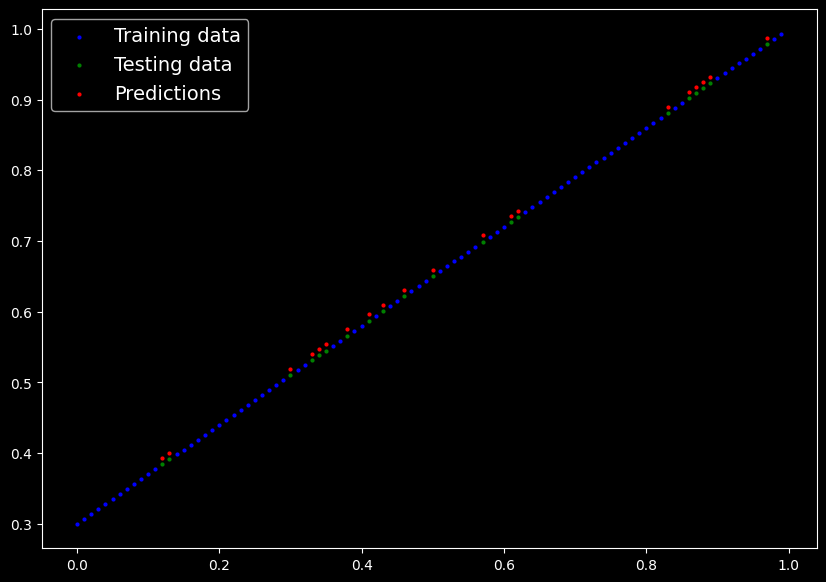

In [132]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [133]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(
    obj=model_1.state_dict(),  # only saving the state_dict() only saves the models learned parameters
    f=MODEL_SAVE_PATH,
)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [134]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [135]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])